In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar
from matplotlib import cm
import utils as ut
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

system_name = 'kite3d_turbo'
run_name = 'norail_final2'
source_dir = '../data/'+system_name+'/'+run_name+'/'
data_dir = '../data/'+system_name+'/'+run_name+'_eval/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'


In [3]:
# READING THE ENVIRONMENTAL PARAMETERS
env_params = ut.read_params(source_dir+'param_env.txt')
for ep in env_params:
    print(ep, env_params[ep])
alg_params = ut.read_params(source_dir+'param_alg.txt')
for ep in alg_params:
    print(ep, alg_params[ep])

int_steps 0.001
ep_length 350.0
ep_length_eval 600.0
decision_time 0.25
alphas [  6.   8.  10.  12.  14.  16.  18.  20.]
CL_alphas [ 0.65  0.75  0.82  0.9   1.    1.08  1.1   1.05]
CD_alphas [ 0.05  0.07  0.09  0.1   0.13  0.18  0.18  0.21]
init_theta 1.0471975511965976
init_dtheta 0.0
init_alpha 7.0
beta_bins [-1.57079633 -1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293
  0.52359878  0.87266463  1.22173048  1.57079633]
banks [-0.26179939 -0.20943951 -0.15707963 -0.10471976 -0.05235988  0.
  0.05235988  0.10471976  0.15707963  0.20943951  0.26179939]
init_bank 5.0
init_phi 0.0
init_dphi 0.0
wind_type turbo
wind_amplification 1.0
windv_file_dir ../data/kite3d_turbo/v1/
windv_file_name velocities
windq_file_path ../data/kite3d_turbo/q.txt
start_frame 1000.0
alg_type sarsa
gamma 1.0
n_steps 600000000.0
traj_points 1000.0
eval_steps 0.0
lr0 0.1
lr1 0.01
n0 10000.0
lrc 4000000.0
lr_expn 0.6
lr_burn0 300000000.0
lr_burn1 300000000.0
eps0 0.01
epsc 4000000.0
eps_expn 1.0
eps_burn 2

In [4]:
m_s = ut.read_best_quality(data_dir + "/occ_matrix2.txt")
m_s = np.array(m_s, dtype=int)
print(m_s)

[[  0   0   0 ...,   1   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0 121   0]
 ..., 
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]


In [5]:
n_alphas = len(env_params['alphas'])
n_banks = len(env_params['banks'])
n_betas = len(env_params['beta_bins']) - 1
tensor = np.zeros((n_alphas, n_banks, n_betas))

for n in range(n_alphas):
    for i in range(n_banks):
        for j in range(n_betas):
            for k in range(9): 
                if m_s[n*n_banks*n_betas+i*n_betas+j][k] != 0:
                    tensor[n][i][j] = m_s[n*n_banks*n_betas+i*n_betas+j][k]

tensor = np.array(tensor, dtype=int)
#tensor = np.transpose(tensor)
print(tensor)


[[[    1    78   121   127   135   142   172    59     1]
  [    1    62    80    39    47    24    42     8     0]
  [    1    78    33    52    77    80    63     9     0]
  [    0    17    71    56    50    44    30     2     0]
  [    0     0     0     1    32    29     8     2     0]
  [    0     0     0     0    17     0     0     0     0]
  [    0     0     0     0    13     0     0     0     0]
  [    0     1    13    15    18    26     1     1     0]
  [    1    32    26    31    51    48    22     6     0]
  [    0    24     9    16    17    12     5     2     0]
  [    0     1     3     4    17     5    12     1     0]]

 [[    1    15    31    47    56    35    37    13     0]
  [    1    59    44    48    75    93    83    29     0]
  [    0     5     2     3     2     9     8     0     0]
  [    0     1     0     2     4     9    16     0     0]
  [    0     0     0     0     2    14    16     4     0]
  [    0     0     0     0     0     0     0     0     0]
  [    0    

In [6]:
aggr_s_traj, labels = ut.read_traj(data_dir+'ev_aggr_st.txt')
aggr_s_i_traj = np.array(aggr_s_traj[:,0], dtype=int)

In [7]:
beta_list = []
if system_name != "kite3d":
    for i in range(len(env_params['beta_bins'])-1):
        beta_list.append((env_params['beta_bins'][i] + env_params['beta_bins'][i+1])/2.0)
else:
    beta_list.append(0)
    env_params['beta_bins'] = np.linspace(-np.pi/2, np.pi/2, 2)
    #env_params['beta_bins'].append(-np.pi/2)
    #env_params['beta_bins'].append(np.pi/2)

In [8]:
def aggr_state_index_translator(index, n_betas, n_banks):
    beta = index % n_betas
    rest = index // n_betas
    bank = rest % n_banks
    alpha = rest // n_banks
    return beta, bank, alpha

In [9]:
beta_i, bank_i, alpha_i = aggr_state_index_translator(aggr_s_i_traj, len(env_params['beta_bins'])-1, len(env_params['banks']))
alphas = np.take(env_params['alphas'], alpha_i)
banks = np.rad2deg(np.take(env_params['banks'], bank_i))
betas = np.rad2deg(np.take(beta_list, beta_i))

In [10]:
xs = []
ys = []
zs = []
m_s1 = []

for n in range(n_alphas):
    for i in range(n_banks):
        for j in range(n_betas):
            xs.append(env_params['alphas'][n])
            ys.append(np.rad2deg(env_params['banks'][i]))
            zs.append(np.rad2deg((env_params['beta_bins'][j] + env_params['beta_bins'][j+1])/2.))
            m_s1.append(tensor[n][i][j])
            

In [11]:
m_max = max(m_s1)

transp = m_s1/m_max

m_slog = np.zeros(len(m_s1))

for i in range(len(m_s1)):
    m_slog[i] = np.log(m_s1[i]+1)

transp_log = m_slog/max(m_slog)

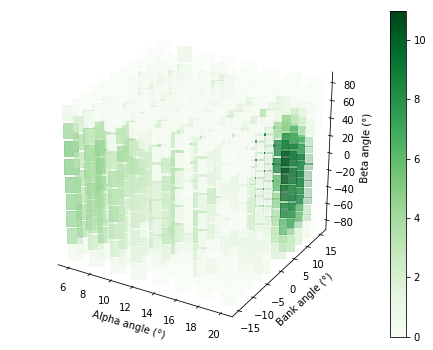

In [12]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog)
#alpha.set_array(transp)

ax.scatter(xs, ys, zs, marker='s', c = m_slog, s=220, cmap='Greens');
#for i in range(n_alphas*n_banks*n_betas):
    #ax.scatter(xs[i], ys[i], zs[i], marker='s', c="g", alpha=transp[i], s=220)

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
'''for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)'''

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


cb = fig.colorbar(colmap)


plt.show()

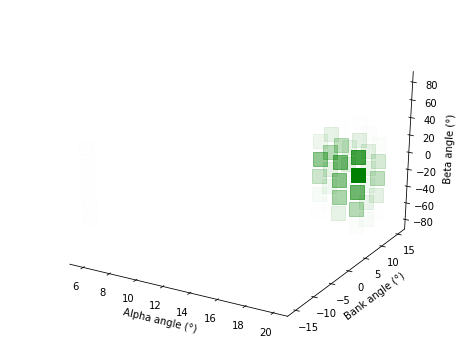

In [13]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_s1)
#alpha.set_array(transp)

#ax.scatter(xs, ys, zs, marker='s', c = m_s1, alpha=transp, s=220, cmap='Greens');
for i in range(n_alphas*n_banks*n_betas):
    ax.scatter(xs[i], ys[i], zs[i], marker='s', c="g", alpha=transp[i], s=220)

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
'''for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)'''

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


#cb = fig.colorbar(colmap)


plt.show()

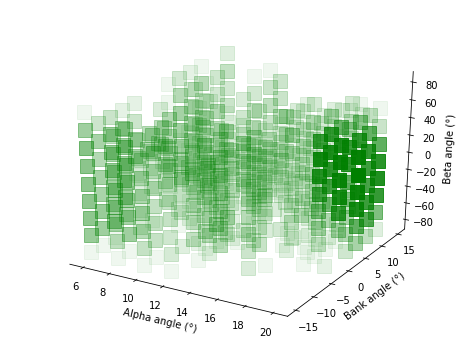

In [14]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog)
#alpha.set_array(transp)

#ax.scatter(xs, ys, zs, marker='s', c = m_slog, s=220, cmap='Greens');
for i in range(n_alphas*n_banks*n_betas):
    ax.scatter(xs[i], ys[i], zs[i], marker='s', c="g", alpha=transp_log[i], s=220)

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
'''for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)'''

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


#cb = fig.colorbar(colmap)


plt.show()

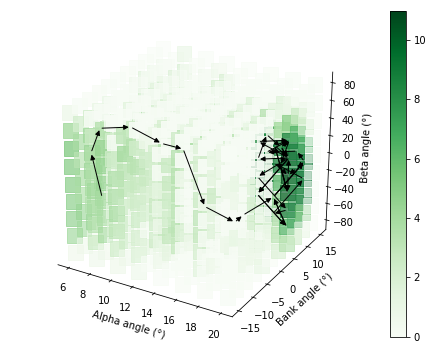

In [18]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog)

ax.scatter(xs, ys, zs, marker='s', c = m_slog, s=220, cmap='Greens');

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


cb = fig.colorbar(colmap)


plt.show()

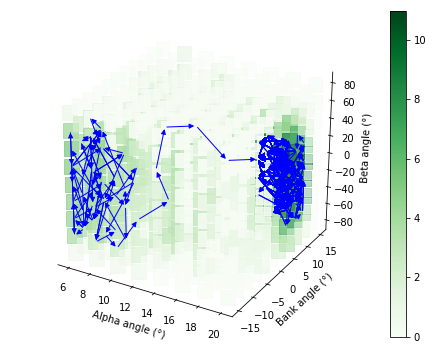

In [19]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog)

ax.scatter(xs, ys, zs, marker='s', c = m_slog, s=220, cmap='Greens');

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
'''for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)'''

for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)


cb = fig.colorbar(colmap)


plt.show()

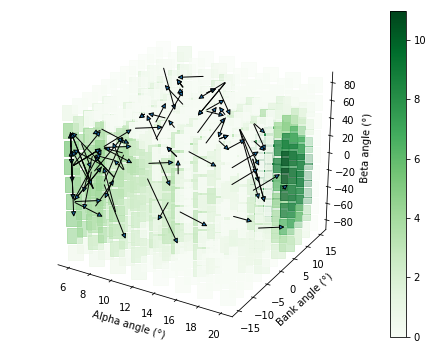

In [20]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(n_betas))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_xticklabels(["6°", "8°", "10°", "12°", "14°", "16°", "18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Alpha angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Beta angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog)

ax.scatter(xs, ys, zs, marker='s', c = m_slog, s=220, cmap='Greens');

for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)
    
'''for i in range(1,50):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    ax.add_artist(a)'''

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


cb = fig.colorbar(colmap)


plt.show()

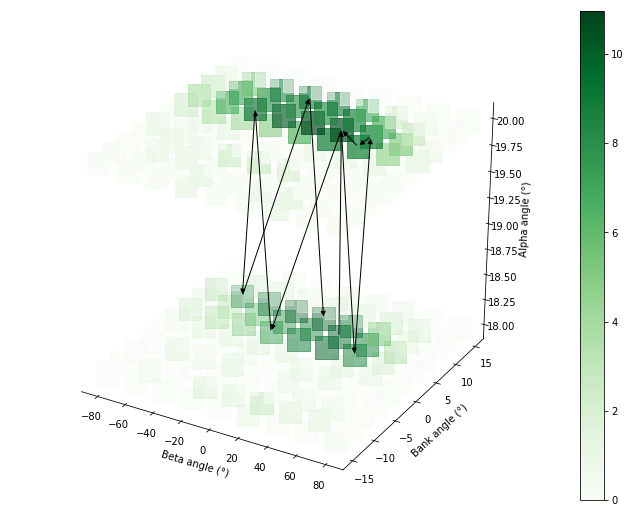

In [73]:
# Create figure and add axis
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

#ax.yaxis.set_ticks(np.arange(n_banks))
#ax.set_xticks(np.arange(n_alphas))
#ax.set_zticks(np.arange(3))
#ax.yaxis.set_ticklabels(["- 15°", "- 12°", "- 9°", "- 6°", "- 3°",  "0°", "3°", "6°", "9°", "12°", "15°"])
#ax.set_zticklabels(["18°", "20°"])
#ax.set_zticklabels(["- 80°", "- 60°", "- 40°", "- 20°", "0°", "20°", "40°", "60°", "80°"])
ax.set_xlabel("Beta angle (°)")
ax.set_ylabel("Bank angle (°)")
ax.set_zlabel("Alpha angle (°)")

colmap = cm.ScalarMappable(cmap=cm.Greens)
colmap.set_array(m_slog[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas])

ax.scatter(zs[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas], 
           ys[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas], 
           xs[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas], 
           marker='s', c = m_slog[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas], s=500, cmap='Greens');

'''for i in range(1,100):
    a = Arrow3D([alphas[(i*2401+10)], alphas[(i*2401+11)]], 
                [banks[(i*2401+10)], banks[(i*2401+11)]], 
                [betas[(i*2401+10)], betas[(i*2401+11)]], mutation_scale=10, 
                lw=1, arrowstyle="-|>")
    ax.add_artist(a)'''
    
for i in range(180,190):
    a = Arrow3D([betas[i], betas[i+1]],
                [banks[i], banks[i+1]], 
                [alphas[i], alphas[i+1]],mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="black")
    #print(alphas[i])
    ax.add_artist(a)

'''for i in range(1*2401+1,1*2401+1350):
    a = Arrow3D([alphas[i], alphas[i+1]], 
                [banks[i], banks[i+1]], 
                [betas[i], betas[i+1]], mutation_scale=10, 
                lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a)'''


cb = fig.colorbar(colmap)
#print(xs[(n_alphas-2)*n_banks*n_betas:(n_alphas)*n_banks*n_betas])

plt.savefig(plot_dir+"stationary_policy.png")
plt.show()